# 데이터 로드 및 확인

### 데이터 확인
* rating: 제품에 대한 평점
* date: 리뷰 작성 날짜
* variation: 제품의 색상 및 기타 변형 정보
* verified_reviews: 실제 리뷰 텍스트
* feedback: 긍정적인 피드백 여부 (1: 긍정적, 0: 부정적)

In [1]:
import pandas as pd

# 데이터 파일 경로
file_path = 'data/amazon_alexa.tsv'
# 데이터 로드
alexa_data = pd.read_csv(file_path, sep='\t')
# 데이터 상위 5개 행 확인
alexa_data.head()


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
alexa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


# 텍스트 전처리

### null, 공백 리뷰 제거, 불용어 제거, 표제어 처리, 소문자 변환

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# NLTK 불용어 리스트 다운로드
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 불용어, 표제어 리스트 가져오기
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def transform_text(text):
    # 소문자 변환
    text = text.lower()
    
    # 특수 문자 및 숫자 제거
    text = re.sub("[^a-zA-Z\s]", "", re.sub('\n', '', text))

    # 불용어
    tokens = word_tokenize(text)
    new_string = []
    for w in tokens:
        if w not in stop_words:
            new_string.append(w)

    s = ' '.join(new_string)
    s = s.strip()

    # 표제어
    tokens = word_tokenize(s)
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos='v')
        new_string.append(lem)

    s = ' '.join(new_string)
    return s.strip()


# 1차 null 및 공백 리뷰 제거
empty_review = alexa_data['verified_reviews'].replace(' ', '') == ''
null_review = alexa_data['verified_reviews'].isnull()
cleaned_df = alexa_data.drop(alexa_data[empty_review | null_review].index)

# 전처리 적용
cleaned_df['cleaned_reviews'] = cleaned_df['verified_reviews'].apply(transform_text)

# 전처리 후 2차 null 및 공백 리뷰 제거
empty_review = cleaned_df['cleaned_reviews'].replace(' ', '') == ''
null_review = cleaned_df['cleaned_reviews'].isnull()
cleaned_df = cleaned_df.drop(cleaned_df[empty_review | null_review].index)

# 전처리 후 데이터 확인
cleaned_df[['verified_reviews', 'cleaned_reviews']].head()


# 텍스트 백터화 및 모델 학습 준비

## 데이터 준비 및 벡터화

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 텍스트 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 평점(rating) 데이터 준비
y = cleaned_df['rating']  # 1~5 사이의 평점

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 모델 학습(RF)

In [6]:
# 랜덤 포레스트 모델 학습 (다중 클래스 분류)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"평점 예측 모델 정확도: {accuracy:.4f}")


평점 예측 모델 정확도: 0.8189


## 모델 성능 평가 (혼동 행렬 및 분류 보고서)

In [7]:
# 혼동 행렬 및 분류 보고서 출력
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("혼동 행렬:")
print(conf_matrix)
print("결과:")
print(class_report)


혼동 행렬:
[[ 10   0   0   1  16]
 [  1   3   0   0  13]
 [  0   0   8   0  18]
 [  0   1   0  38  57]
 [  1   0   0   3 443]]
결과:
              precision    recall  f1-score   support

           1       0.83      0.37      0.51        27
           2       0.75      0.18      0.29        17
           3       1.00      0.31      0.47        26
           4       0.90      0.40      0.55        96
           5       0.81      0.99      0.89       447

    accuracy                           0.82       613
   macro avg       0.86      0.45      0.54       613
weighted avg       0.83      0.82      0.79       613



# 시각화

## 분류 모델 시각화

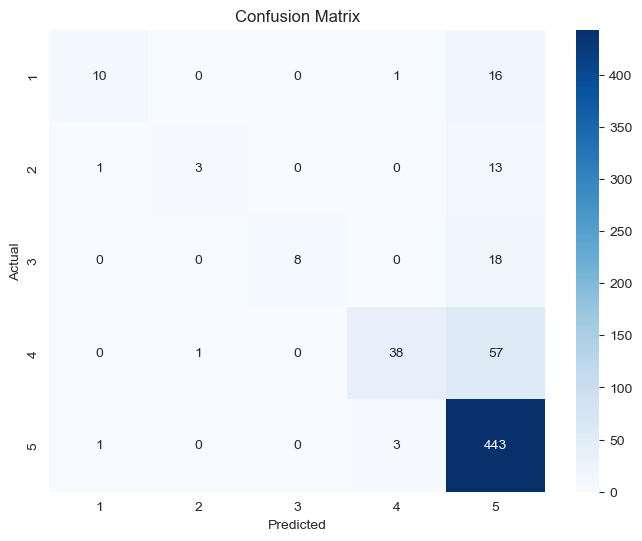

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 결과

## 오분류 된 리뷰 확인
* 기존 점수와 예측된 점수가 2점이상 차이가 나는 리뷰를 오분류됨으로 정의

In [9]:
# 예측 결과 저장 (y_pred는 이미 예측된 결과)
cleaned_df['predicted_rating'] = rf_model.predict(X)
# 실제 값과 예측 값 비교
mismatched_reviews = cleaned_df[cleaned_df['rating'] != cleaned_df['predicted_rating']]
# 잘못 예측된 리뷰들 확인
misclassification_df = mismatched_reviews[['verified_reviews', 'cleaned_reviews', 'rating', 'predicted_rating']][abs(mismatched_reviews['rating'] - mismatched_reviews['predicted_rating']) >= 2]

misclassification_df.to_csv('out/misclassification_df.csv', index=False)
